In [ ]:
!git clone https://github.com/myproject-01/covid_tb_pneumonia.git

fatal: destination path 'covid_tb_pneumonia' already exists and is not an empty directory.


In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from imutils import paths
import numpy as np
import argparse
import os
import matplotlib.pyplot as plt
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array

class ImageToArrayPreprocessor:
	def __init__(self, dataFormat=None):
		# store the image data format
		self.dataFormat = dataFormat

	def preprocess(self, image):
		# apply the Keras utility function that correctly rearranges
		# the dimensions of the image
		return img_to_array(image, data_format=self.dataFormat)

In [ ]:
# import the necessary packages
import imutils
import cv2

class AspectAwarePreprocessor:
	def __init__(self, width, height, inter=cv2.INTER_AREA):
		# store the target image width, height, and interpolation
		# method used when resizing
		self.width = width
		self.height = height
		self.inter = inter

	def preprocess(self, image):
		# grab the dimensions of the image and then initialize
		# the deltas to use when cropping
		(h, w) = image.shape[:2]
		dW = 0
		dH = 0

		# if the width is smaller than the height, then resize
		# along the width (i.e., the smaller dimension) and then
		# update the deltas to crop the height to the desired
		# dimension
		if w < h:
			image = imutils.resize(image, width=self.width,
				inter=self.inter)
			dH = int((image.shape[0] - self.height) / 2.0)

		# otherwise, the height is smaller than the width so
		# resize along the height and then update the deltas
		# crop along the width
		else:
			image = imutils.resize(image, height=self.height,
				inter=self.inter)
			dW = int((image.shape[1] - self.width) / 2.0)

		# now that our images have been resized, we need to
		# re-grab the width and height, followed by performing
		# the crop
		(h, w) = image.shape[:2]
		image = image[dH:h - dH, dW:w - dW]

		# finally, resize the image to the provided spatial
		# dimensions to ensure our output image is always a fixed
		# size
		return cv2.resize(image, (self.width, self.height),
			interpolation=self.inter)

In [ ]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")




In [ ]:

class DeeperGoogLeNet:
	@staticmethod
	def conv_module(x, K, kX, kY, stride, chanDim,
		padding="same", reg=0.0005, name=None):
		# initialize the CONV, BN, and RELU layer names
		(convName, bnName, actName) = (None, None, None)

		# if a layer name was supplied, prepend it
		if name is not None:
			convName = name + "_conv"
			bnName = name + "_bn"
			actName = name + "_act"

		# define a CONV => BN => RELU pattern
		x = Conv2D(K, (kX, kY), strides=stride, padding=padding,
			kernel_regularizer=l2(reg), name=convName)(x)
		x = BatchNormalization(axis=chanDim, name=bnName)(x)
		x = Activation("relu", name=actName)(x)

		# return the block
		return x

	@staticmethod
	def inception_module(x, num1x1, num3x3Reduce, num3x3,
		num5x5Reduce, num5x5, num1x1Proj, chanDim, stage,
		reg=0.0005):
		# define the first branch of the Inception module which
		# consists of 1x1 convolutions
		first = DeeperGoogLeNet.conv_module(x, num1x1, 1, 1,
			(1, 1), chanDim, reg=reg, name=stage + "_first")

		# define the second branch of the Inception module which
		# consists of 1x1 and 3x3 convolutions
		second = DeeperGoogLeNet.conv_module(x, num3x3Reduce, 1, 1,
			(1, 1), chanDim, reg=reg, name=stage + "_second1")
		second = DeeperGoogLeNet.conv_module(second, num3x3, 3, 3,
			(1, 1), chanDim, reg=reg, name=stage + "_second2")

		# define the third branch of the Inception module which
		# are our 1x1 and 5x5 convolutions
		third = DeeperGoogLeNet.conv_module(x, num5x5Reduce, 1, 1,
			(1, 1), chanDim, reg=reg, name=stage + "_third1")
		third = DeeperGoogLeNet.conv_module(third, num5x5, 5, 5,
			(1, 1), chanDim, reg=reg, name=stage + "_third2")

		# define the fourth branch of the Inception module which
		# is the POOL projection
		fourth = MaxPooling2D((3, 3), strides=(1, 1),
			padding="same", name=stage + "_pool")(x)
		fourth = DeeperGoogLeNet.conv_module(fourth, num1x1Proj,
			1, 1, (1, 1), chanDim, reg=reg, name=stage + "_fourth")

		# concatenate across the channel dimension
		x = concatenate([first, second, third, fourth], axis=chanDim,
			name=stage + "_mixed")

		# return the block
		return x

	@staticmethod
	def build(width, height, depth, classes, reg=0.0005):
		# initialize the input shape to be "channels last" and the
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# define the model input, followed by a sequence of CONV =>
		# POOL => (CONV * 2) => POOL layers
		inputs = Input(shape=inputShape)
		x = DeeperGoogLeNet.conv_module(inputs, 64, 5, 5, (1, 1),
			chanDim, reg=reg, name="block1")
		x = MaxPooling2D((3, 3), strides=(2, 2), padding="same",
			name="pool1")(x)
		x = DeeperGoogLeNet.conv_module(x, 64, 1, 1, (1, 1),
			chanDim, reg=reg, name="block2")
		x = DeeperGoogLeNet.conv_module(x, 192, 3, 3, (1, 1),
			chanDim, reg=reg, name="block3")
		x = MaxPooling2D((3, 3), strides=(2, 2), padding="same",
			name="pool2")(x)

		# apply two Inception modules followed by a POOL
		x = DeeperGoogLeNet.inception_module(x, 64, 96, 128, 16,
			32, 32, chanDim, "3a", reg=reg)
		x = DeeperGoogLeNet.inception_module(x, 128, 128, 192, 32,
			96, 64, chanDim, "3b", reg=reg)
		x = MaxPooling2D((3, 3), strides=(2, 2), padding="same",
			name="pool3")(x)

		# apply five Inception modules followed by POOL
		x = DeeperGoogLeNet.inception_module(x, 192, 96, 208, 16,
			48, 64, chanDim, "4a", reg=reg)
		x = DeeperGoogLeNet.inception_module(x, 160, 112, 224, 24,
			64, 64, chanDim, "4b", reg=reg)
		x = DeeperGoogLeNet.inception_module(x, 128, 128, 256, 24,
			64, 64, chanDim, "4c", reg=reg)
		x = DeeperGoogLeNet.inception_module(x, 112, 144, 288, 32,
			64, 64, chanDim, "4d", reg=reg)
		x = DeeperGoogLeNet.inception_module(x, 256, 160, 320, 32,
			128, 128, chanDim, "4e", reg=reg)
		x = MaxPooling2D((3, 3), strides=(2, 2), padding="same",
			name="pool4")(x)

		# apply a POOL layer (average) followed by dropout
		x = AveragePooling2D((4, 4), name="pool5")(x)
		x = Dropout(0.4, name="do")(x)

		# softmax classifier
		x = Flatten(name="flatten")(x)
		x = Dense(classes, kernel_regularizer=l2(reg),
			name="labels")(x)
		x = Activation("softmax", name="softmax")(x)

		# create the model
		model = Model(inputs, x, name="googlenet")

		# return the constructed network architecture
		return model



In [ ]:
# import the necessary packages
import numpy as np
import cv2
import os

class SimpleDatasetLoader:
	def __init__(self, preprocessors=None):
		# store the image preprocessor
		self.preprocessors = preprocessors

		# if the preprocessors are None, initialize them as an
		# empty list
		if self.preprocessors is None:
			self.preprocessors = []

	def load(self, imagePaths, verbose=-1):
		# initialize the list of features and labels
		data = []
		labels = []

		# loop over the input images
		for (i, imagePath) in enumerate(imagePaths):
			# load the image and extract the class label assuming
			# that our path has the following format:
			# /path/to/dataset/{class}/{image}.jpg
			image = cv2.imread(imagePath)
			label = imagePath.split(os.path.sep)[-2]

			# check to see if our preprocessors are not None
			if self.preprocessors is not None:
				# loop over the preprocessors and apply each to
				# the image
				for p in self.preprocessors:
					image = p.preprocess(image)

			# treat our processed image as a "feature vector"
			# by updating the data list followed by the labels
			data.append(image)
			labels.append(label)

			# show an update every `verbose` images
			if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
				print("[INFO] processed {}/{}".format(i + 1,
					len(imagePaths)))

		# return a tuple of the data and labels
		return (np.array(data), np.array(labels))

In [ ]:
# grab the list of images that we'll be describing, then extract
# the class label names from the image paths
print("[INFO] loading images...")
imagePaths = list(paths.list_images("covid_tb_pneumonia/images/"))
classNames = [pt.split(os.path.sep)[-2] for pt in imagePaths]
classNames = [str(x) for x in np.unique(classNames)]

# initialize the image preprocessors
aap = AspectAwarePreprocessor(64, 64)
iap = ImageToArrayPreprocessor()

# load the dataset from disk then scale the raw pixel intensities to
# the range [0, 1]
sdl = SimpleDatasetLoader(preprocessors=[aap, iap])
(data, labels) = sdl.load(imagePaths, verbose=100)
data = data.astype("float") / 255.0


[INFO] loading images...
[INFO] processed 100/1027
[INFO] processed 200/1027
[INFO] processed 300/1027
[INFO] processed 400/1027
[INFO] processed 500/1027
[INFO] processed 600/1027
[INFO] processed 700/1027
[INFO] processed 800/1027
[INFO] processed 900/1027
[INFO] processed 1000/1027


In [ ]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.25, random_state=42)

# convert the labels from integers to vectors
trainY = LabelBinarizer().fit_transform(trainY)
testY = LabelBinarizer().fit_transform(testY)





[INFO] compiling model...
[INFO] training head...
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


24/24 [==============================] - 7s 109ms/step - loss: 4.2348 - accuracy: 0.5957 - val_loss: 5.3789 - val_accuracy: 0.1673
Epoch 2/100
24/24 [==============================] - 1s 60ms/step - loss: 3.2727 - accuracy: 0.8394 - val_loss: 7.0703 - val_accuracy: 0.1673
Epoch 3/100
24/24 [==============================] - 2s 63ms/step - loss: 3.1600 - accuracy: 0.8690 - val_loss: 9.5969 - val_accuracy: 0.2023
Epoch 4/100
24/24 [==============================] - 2s 61ms/step - loss: 3.2767 - accuracy: 0.8571 - val_loss: 14.9988 - val_accuracy: 0.1673
Epoch 5/100
24/24 [==============================] - 2s 64ms/step - loss: 3.0971 - accuracy: 0.8905 - val_loss: 28.1406 - val_accuracy: 0.1673
Epoch 6/100
24/24 [==============================] - 2s 62ms/step - loss: 2.9826 - accuracy: 0.8942 - val_loss: 21.9200 - val_accuracy: 0.1673
Epoch 7/100
24/24 [==============================] - 1s 61ms/step - loss: 2.9598 - accuracy: 0.8842 - val_loss: 20.5464 - val_accuracy: 0.1673
Epoch 8/100
2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Covid       0.90      0.76      0.82        37
   Pneumonia       1.00      0.46      0.63        37
      ignore       0.74      1.00      0.85        43
      normal       0.00      0.00      0.00        45
tuberculosis       0.58      0.92      0.71        95

    accuracy                           0.68       257
   macro avg       0.64      0.63      0.60       257
weighted avg       0.61      0.68      0.61       257

[INFO] re-compiling model...
[INFO] fine-tuning model...
Epoch 1/80
24/24 [==============================] - 7s 106ms/step - loss: 0.7555 - accuracy: 0.9356 - val_loss: 1.8117 - val_accuracy: 0.7276
Epoch 2/80
24/24 [==============================] - 1s 60ms/step - loss: 0.7389 - accuracy: 0.9397 - val_loss: 1.6655 - val_accuracy: 0.7510
Epoch 3/80
24/24 [==============================] - 1s 61ms/step - loss: 0.7881 - accuracy: 0.9124 - val_loss: 1.4212 - val_accuracy: 0.7782
Epoch 4/80
24/24 [============

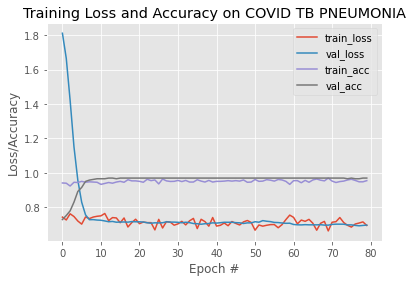

In [ ]:
model = DeeperGoogLeNet.build(64, 64, 3, 5)

print("[INFO] compiling model...")
opt = Adam(lr=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])


print("[INFO] training head...")
model.fit_generator(aug.flow(trainX, trainY, batch_size=32),
	validation_data=(testX, testY), epochs=100,
	steps_per_epoch=len(trainX) // 32, verbose=1)

# evaluate the network after initialization
print("[INFO] evaluating after initialization...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=classNames))
print("[INFO] re-compiling model...")
opt = SGD(lr=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])


print("[INFO] fine-tuning model...")
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=32),
	validation_data=(testX, testY), epochs=80,
	steps_per_epoch=len(trainX) // 32, verbose=1)

for key in H.history.keys():
    print(key)
# evaluate the network on the fine-tuned model
print("[INFO] evaluating after fine-tuning...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=classNames))


# save the model to disk
print("[INFO] serializing model...")
model.save("output.model")

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 80), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 80), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 80), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 80), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID TB PNEUMONIA")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("output.png")
